In [1]:
project_id = 'elife-data-pipeline'
source_dataset = 'de_dev'
output_dataset = 'de_dev'
output_table_prefix = 'data_science_'
state_path = 's3://ci-elife-data-pipeline/airflow-config/data-science/state-dev'
max_workers = 10
max_manuscripts = 1000

In [2]:
import json
import re
import os
import sys
import logging
from datetime import datetime
from functools import partial
from concurrent.futures import ThreadPoolExecutor 
from typing import List

import numpy as np
import pandas as pd
import requests
from tqdm.auto import tqdm

import google.cloud.exceptions

import data_science_pipeline.configure_warnings

from data_science_pipeline.sql import get_sql
from data_science_pipeline.utils.europepmc import (
    EUROPEPMC_MAX_PAGE_SIZE,
    EuropePMCApi,
    europepmc_requests_retry_session
)
from data_science_pipeline.utils.misc import iter_batches
from data_science_pipeline.utils.bq import (
    is_bq_not_found_exception,
    load_json_list_and_append_to_bq_table_with_auto_schema
)
from data_science_pipeline.utils.pandas import read_csv
from data_science_pipeline.utils.jupyter import (
    read_big_query as _read_big_query,
)

In [3]:
logging.basicConfig(level='INFO')
# logging.getLogger('data_science_pipeline.utils.bq').setLevel(logging.DEBUG)

In [4]:
LOGGER = logging.getLogger(__name__)

In [5]:
editor_pubmed_ids_path = os.path.join(state_path, 'editor_pubmed_ids.tsv.gz')
external_manuscript_summary_output_table_name = '{output_dataset}.{prefix}{suffix}'.format(
    output_dataset=output_dataset,
    prefix=output_table_prefix,
    suffix='external_manuscript_summary'
)

In [6]:
read_big_query = partial(_read_big_query, project_id=project_id)

In [7]:
_sql = (
    'SELECT pmid FROM `{table}`'
).format(table=external_manuscript_summary_output_table_name)

try:
    existing_pmids_df = read_big_query(_sql)
except Exception as e:
    if not is_bq_not_found_exception(e):
        raise
    print('table not found: %s', external_manuscript_summary_output_table_name)
    existing_pmids_df = pd.DataFrame(columns=['pmid'])
print(len(existing_pmids_df))
existing_pmids_df.head()

> ```sql
> SELECT pmid FROM `de_dev.data_science_external_manuscript_summary`
> ```

Downloading: 100%|██████████| 1998/1998 [00:00<00:00, 2450.15rows/s]

1998


,pmid
0,31628140
1,31493833
2,31335853
3,30571938
4,29475451


In [8]:
existing_pmids_df.dtypes

pmid    object
dtype: object

In [9]:
existing_pmids_set = set(existing_pmids_df['pmid'])
len(existing_pmids_set)

999

In [10]:
editor_pubmed_ids_df = read_csv(
    editor_pubmed_ids_path,
    dtype={'person_id': 'str'},
    converters={
        'pubmed_ids': lambda s: s.split('|')
    }
)
editor_pubmed_ids_df.head()

,person_id,name,pubmed_url,pubmed_ids
0,126873,Yuuki Watanabe,https://www.ncbi.nlm.nih.gov/pubmed/?term=Wata...,"[31778207, 31187501, 31340216, 30777873, 30232..."
1,178962,Chima Nwaogu,https://www.ncbi.nlm.nih.gov/pubmed/?term=Nwao...,"[32246110, 31764994, 30659607, 30956931]"
2,70207,Bernhard Schmid,https://www.ncbi.nlm.nih.gov/pubmed/?term=Schm...,"[32504789, 32486982, 32427483, 32407371, 32333..."
3,14193,Merijn Kant,https://www.ncbi.nlm.nih.gov/pubmed?term=Kant%...,"[26019168, 23238958, 11256409]"
4,7970,Laurent Keller,https://www.ncbi.nlm.nih.gov/pubmed/?term=Kell...,"[32353492, 32415359, 32271631, 32298574, 32244..."


In [11]:
len(editor_pubmed_ids_df)

616

In [12]:
# check that the type is a proper list
editor_pubmed_ids_df['pubmed_ids'].values[0]

['31778207',
 '31187501',
 '31340216',
 '30777873',
 '30232531',
 '29951206',
 '29780593',
 '29444848',
 '29323131',
 '27551383',
 '27457414',
 '27305867',
 '26139663',
 '26061229',
 '25377461',
 '25902489',
 '24478293',
 '24477606',
 '23341596',
 '23857645',
 '23014571',
 '21832140',
 '21270312',
 '21228200',
 '20946384']

In [13]:
editor_pubmed_ids_df['pubmed_count'] = editor_pubmed_ids_df['pubmed_ids'].apply(len)
print((editor_pubmed_ids_df['pubmed_count'] >= 1000).sum())
editor_pubmed_ids_df.sort_values('pubmed_count', ascending=False).head(10)

62


,person_id,name,pubmed_url,pubmed_ids,pubmed_count
437,33159,Wenwei Hu,https://www.ncbi.nlm.nih.gov/pubmed/?term=Hu%2...,"[32390016, 32373871, 32215387, 32026907, 31960...",1000
553,63487,Eric Wagner,https://www.ncbi.nlm.nih.gov/pubmed/?term=Wagn...,"[32475206, 32498278, 32486855, 32463457, 32474...",1000
354,1880,Kang Shen,https://www.ncbi.nlm.nih.gov/pubmed?term=Shen%...,"[31165134, 30968914, 32517787, 32516341, 32483...",1000
91,164440,Taraz Lee,https://www.ncbi.nlm.nih.gov/pubmed/?term=Lee%...,"[31490468, 32126634, 32531466, 32532809, 32526...",1000
353,7755,Satyajit Mayor,https://www.ncbi.nlm.nih.gov/pubmed/?term=Mayo...,"[32325021, 32297381, 32291260, 32220898, 32175...",1000
498,97155,Matthias Barton,https://www.ncbi.nlm.nih.gov/pubmed?term=Barto...,"[32505478, 32456669, 32492811, 32482884, 32282...",1000
80,19516,Huan Luo,https://www.ncbi.nlm.nih.gov/pubmed?term=Luo%2...,"[32207492, 32129360, 32025673, 32228103, 31746...",1000
507,1178,Shimon Sakaguchi,https://www.ncbi.nlm.nih.gov/pubmed?term=Sakag...,"[32522901, 32414925, 32530645, 32310734, 32367...",1000
77,72659,Jeffrey Smith,https://www.ncbi.nlm.nih.gov/pubmed/?term=Smit...,"[32432296, 31065643, 32528015, 32433861, 32533...",1000
336,170567,Sang-Gyu Kim,https://www.ncbi.nlm.nih.gov/pubmed/?term=Kim%...,"[31334742, 30706934, 31106317, 32520523, 32520...",1000


In [14]:
print('editors with >= 1000 pubmed ids:\n%s' % '\n'.join(
    '- %s: %s' % (row['name'], row['pubmed_url'])
    for row in editor_pubmed_ids_df[editor_pubmed_ids_df['pubmed_count'] >= 1000].to_dict(orient='records')
))

editors with >= 1000 pubmed ids:
- Jessica Thompson: https://www.ncbi.nlm.nih.gov/pubmed/?term=Thompson%20J%5BAuthor%5D&cauthor=true&cauthor_uid=28778462
- Min Zhu: https://www.ncbi.nlm.nih.gov/pubmed/?term=Zhu%20M%5BAuthor%5D&cauthor=true&cauthor_uid=29185516
- Xiaochen Wang: https://www.ncbi.nlm.nih.gov/pubmed/?term=Wang%20X%5BAuthor%5D&cauthor=true&cauthor_uid=30102152
- Li Yu: https://www.ncbi.nlm.nih.gov/pubmed/?term=Yu%20L%5BAuthor%5D&cauthor=true&cauthor_uid=31371827
- Junmin Pan: https://www.ncbi.nlm.nih.gov/pubmed/?term=Pan%20J%5BAuthor%5D&cauthor=true&cauthor_uid=30057303
- Mahak Sharma: https://www.ncbi.nlm.nih.gov/pubmed/?term=Sharma%20M%5BAuthor%5D&cauthor=true&cauthor_uid=31010854
- Maddy Parsons: https://www.ncbi.nlm.nih.gov/pubmed/?term=Parsons%20M%5Bauth%5D
- Yue Wang: https://www.ncbi.nlm.nih.gov/pubmed?term=Wang%20Y&orig_db=PubMed&cmd=search
- J Paul Taylor: https://www.ncbi.nlm.nih.gov/pubmed?term=Taylor%20J[au]&orig_db=PubMed&cmd=search
- Jie Xiao: https://www.ncbi

In [15]:
editor_pubmed_ids_df[editor_pubmed_ids_df['pubmed_count'] < 1000]['pubmed_count'].mean()

164.73646209386283

In [16]:
editor_pubmed_ids_df[editor_pubmed_ids_df['pubmed_count'] < 1000]['pubmed_count'].median()

89.0

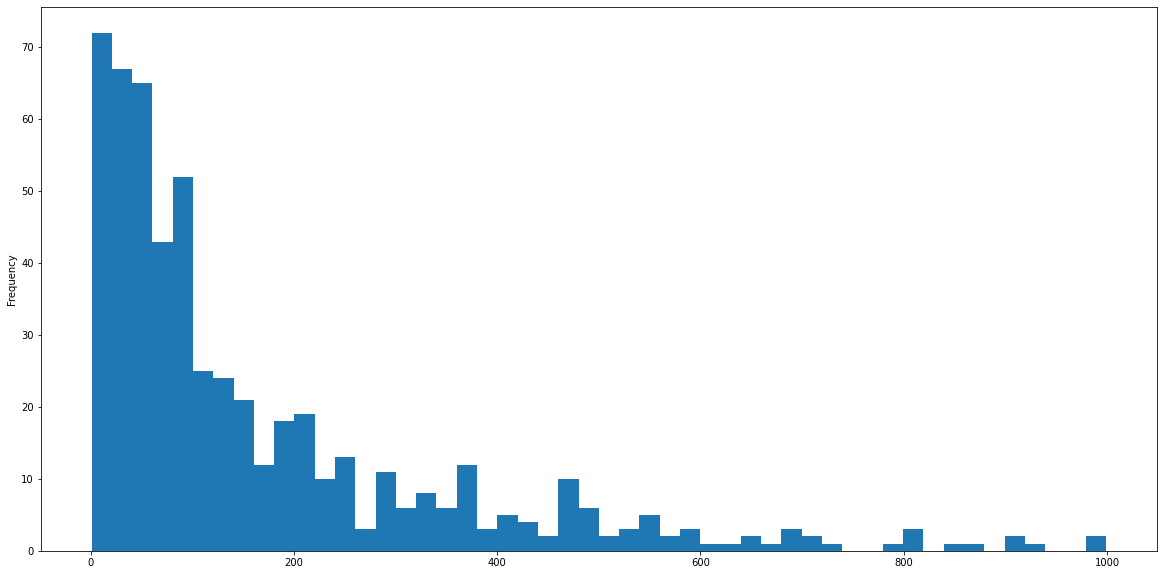

In [17]:
editor_pubmed_ids_df[editor_pubmed_ids_df['pubmed_count'] < 1000]['pubmed_count'].plot.hist(
    bins=50,
    figsize=(20, 10)
)
None

In [18]:
editor_clean_pubmed_ids_df = editor_pubmed_ids_df[editor_pubmed_ids_df['pubmed_count'] < 1000]
print(len(editor_clean_pubmed_ids_df))
editor_clean_pubmed_ids_df.sort_values('pubmed_count', ascending=False).head(10)

554


,person_id,name,pubmed_url,pubmed_ids,pubmed_count
386,53174,Katalin Toth,https://www.ncbi.nlm.nih.gov/pubmed/?term=T%C3...,"[32513869, 32470395, 32329040, 32222134, 32223...",999
453,145041,Margaret Stanley,https://www.ncbi.nlm.nih.gov/pubmed?term=Stanl...,"[32484911, 32445245, 32442096, 32222299, 32359...",990
508,4853,Satyajit Rath,https://www.ncbi.nlm.nih.gov/pubmed?term=Rath%...,"[32513863, 32415095, 32416088, 32434405, 32383...",935
509,110082,Ranjan Sen,https://www.ncbi.nlm.nih.gov/pubmed/?term=Sen%...,"[32525572, 32524736, 32505862, 32464231, 32405...",910
233,11670,Beth Stevens,https://www.ncbi.nlm.nih.gov/entrez/query.fcgi...,"[32533741, 32506118, 32530469, 32461285, 32460...",904
31,1139,Sheila McCormick,https://www.ncbi.nlm.nih.gov/pubmed?term=McCor...,"[32473516, 32388249, 32407107, 32328680, 32237...",877
597,1095,E Peter Greenberg,https://www.ncbi.nlm.nih.gov/pubmed?term=Green...,"[32491160, 32534421, 32439724, 32412083, 32347...",851
27,8364,Piali Sengupta,https://www.ncbi.nlm.nih.gov/pubmed/?term=Seng...,"[31298670, 32496225, 32529205, 32399992, 32492...",815
4,7970,Laurent Keller,https://www.ncbi.nlm.nih.gov/pubmed/?term=Kell...,"[32353492, 32415359, 32271631, 32298574, 32244...",809
333,3258,Ahmet Yildiz,https://pubmed.ncbi.nlm.nih.gov/?term=Yildiz+A...,"[32507098, 32462563, 32452237, 32479829, 32341...",804


In [19]:
all_pubmed_ids = [
    pubmed_id
    for pubmed_ids in editor_clean_pubmed_ids_df.sort_values('pubmed_count')['pubmed_ids'].values
    for pubmed_id in pubmed_ids
]
len(all_pubmed_ids)

91264

In [20]:
unique_pubmed_ids = list(pd.Series(all_pubmed_ids).drop_duplicates().values)
len(unique_pubmed_ids)

89884

In [21]:
_ser = pd.Series(unique_pubmed_ids)
print(_ser[:10])
print(sorted(existing_pmids_set)[:10])
print('287025' in existing_pmids_set)
print(_ser.isin(existing_pmids_set).sum())
remaining_pubmed_ids = list(_ser[~_ser.isin(existing_pmids_set)].values)
len(remaining_pubmed_ids)

0            
1    27149616
2    23675971
3    17976052
4    27572726
5    11717494
6    23444192
7    11378445
8     2985408
9     6099704
dtype: object
['10037483', '10085354', '10090773', '10102825', '10198053', '10200977', '10203789', '10220424', '10331976', '10340509']
True
999


88885

In [22]:
query_pubmed_ids = [
    unique_pubmed_ids
]
if max_manuscripts:
    query_pubmed_ids = unique_pubmed_ids[:max_manuscripts]
len(query_pubmed_ids)

1000

In [23]:
query_pubmed_ids_batches = list(iter_batches(query_pubmed_ids, EUROPEPMC_MAX_PAGE_SIZE))
print('first batch:', len(query_pubmed_ids_batches[0]))
print('number of batches:', len(query_pubmed_ids_batches))

first batch: 1000
number of batches: 1


In [24]:
with europepmc_requests_retry_session() as session:
    europepmc_api = EuropePMCApi(session)
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        manuscript_summary_list_batches = list(tqdm(
            executor.map(
                europepmc_api.get_summary_by_page_pmids,
                query_pubmed_ids_batches
            ),
            total=len(query_pubmed_ids_batches),
            leave=False
        ))

In [25]:
len(manuscript_summary_list_batches)

1

In [26]:
manuscript_summary_flattened = [
    manuscript_summary
    for manuscript_summary_list in manuscript_summary_list_batches
    for manuscript_summary in manuscript_summary_list
]
len(manuscript_summary_flattened)

999

In [27]:
for manuscript_summary in manuscript_summary_flattened:
    manuscript_summary['provenance'] = {
        'source': 'europepmc',
        'imported_timestamp': datetime.utcnow().isoformat()
    }

In [28]:
manuscript_summary_flattened[0]

{'source': 'MED',
 'pmid': '32523985',
 'pmcid': 'PMC7259943',
 'doi': '10.1126/sciadv.aaz1949',
 'title': 'Single-molecule transport kinetics of a glutamate transporter homolog shows static disorder.',
 'authorString': 'Ciftci D, Huysmans GHM, Wang X, He C, Terry D, Zhou Z, Fitzgerald G, Blanchard SC, Boudker O.',
 'authorList': {'author': [{'fullName': 'Ciftci D',
    'firstName': 'Didar',
    'lastName': 'Ciftci',
    'initials': 'D',
    'authorId': {'type': 'ORCID', 'value': '0000-0001-8079-1022'},
    'authorAffiliationsList': {'authorAffiliation': ['Department of Physiology and Biophysics, Weill Cornell Medicine, 1300 York Avenue, New York, NY 10065, USA.',
      'Tri-Institutional Training Program in Chemical Biology, New York, NY 10065, USA.']}},
   {'fullName': 'Huysmans GHM',
    'firstName': 'Gerard H M',
    'lastName': 'Huysmans',
    'initials': 'GHM',
    'authorAffiliationsList': {'authorAffiliation': ['Department of Physiology and Biophysics, Weill Cornell Medicine, 1

In [29]:
print('writing to:', external_manuscript_summary_output_table_name)
load_json_list_and_append_to_bq_table_with_auto_schema(
    manuscript_summary_flattened,
    project_id=project_id,
    table_name=external_manuscript_summary_output_table_name
)
print('done')

writing to: de_dev.data_science_external_manuscript_summary


INFO:root:Processed 999 lines
INFO:data_science_pipeline.utils.bq:Loaded 999 rows into de_dev:data_science_external_manuscript_summary.


done
